### Q2 Meta heuristic algorithm (30%) 

本範例是一個具有20個工件的單機台 flow shop 問題，排程目標為最小化總加權延遲 (Total weighted tardiness) ，工件資訊如下圖所示
1. Initailization population
2. Select parents & Crossover
3. Mutate Offsprings
4. Merge parents and offsprings
5. Evalutate, Sort & Select population
6. Go to step 2

演算參考了
- Paper: Crossover and Mutation Strategies applied in Job Shop Scheduling Problems https://iopscience.iop.org/article/10.1088/1742-6596/1377/1/012031
- Github: https://github.com/wurmen/Genetic-Algorithm-for-Job-Shop-Scheduling-and-NSGA-II/blob/master/implementation%20with%20python/GA-jobshop/GA_For_Jobshop.md

In [ ]:
import numpy as np
import time
import copy
import random
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
def sequence_integrity_test(seq:list) -> bool:
    '''驗證序列是否為合法的工作序列(不重複) O(1)'''
    lenx = len(seq)
    correct_seq = list(range(lenx))
    assert Counter(seq) == Counter(correct_seq), seq
    return True

sequence_integrity_test([0,1,2,3,4]) # True
sequence_integrity_test([0,1,3,3,4]) # AssertionError (3重複了)

AssertionError: [0, 1, 3, 3, 4]

In [ ]:
def PMX_crossover(parent1, parent2):
    # parent1 and parent2 are 1D np.array
    parent1,parent2 = np.array(parent1), np.array(parent2) 
    rng = np.random.default_rng(seed=111)

    cutoff_1, cutoff_2 = np.sort(rng.choice(np.arange(len(parent1)+1), size=2, replace=False))
    # cutoff_1, cutoff_2 = 2 , 7
    # print('cutoff_1, cutoff_2:', cutoff_1, cutoff_2)

    def PMX_one_offspring(p1, p2):
        offspring = np.zeros(len(p1), dtype=p1.dtype)
        
        # Copy the mapping section (middle) from parent1
        offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]
        # print('---\np1:', p1,', p2:', p2)
        # print('elements copied from parent p1:', offspring)

        # copy the rest from parent2 (provided it's not already there
        for i in np.concatenate([np.arange(0,cutoff_1), np.arange(cutoff_2,len(p1))]):
            candidate = p2[i]
            while candidate in p1[cutoff_1:cutoff_2]: # allows for several successive mappings
                # print(f"Candidate {candidate} not valid in position {i}", end='')
                where = np.where(p1 == candidate)[0][0]
                candidate = p2[np.where(p1 == candidate)[0][0]]
                # print(f', will be replaced by {candidate} (p2[{where}]).')
            offspring[i] = candidate
            
        # print('generate offspring:', offspring)
        return offspring.astype(int).tolist()

    offspring1 = PMX_one_offspring(parent1, parent2)
    offspring2 = PMX_one_offspring(parent2, parent1)
    sequence_integrity_test(offspring1)
    sequence_integrity_test(offspring2)

    return offspring1, offspring2

p1 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
p2 = np.array([7,8,9,0,1,2,3,4,5,6,10,11,12,13,14,15])
PMX_crossover(p1, p2)

([7, 8, 2, 3, 4, 5, 6, 1, 9, 0, 10, 11, 12, 13, 14, 15],
 [6, 4, 9, 0, 1, 2, 3, 7, 8, 5, 10, 11, 12, 13, 14, 15])

In [ ]:
def shift_mutation(offspring: list, num_mutation_jobs: int, mutation_rate:int, test=False):
    ''' offspring: input list to be mutate, num_mutation_jobs: seq len to be shifted '''
    mutation_prob = np.random.rand()
    if test:
        mutation_prob = 0
    if mutation_rate >= mutation_prob:
        num_job = len(offspring)
        m_chg = list(np.random.choice(num_job, num_mutation_jobs, replace=False)) # chooses the position to shift mutation
        t_value_last = offspring[m_chg[0]] # save the value which is on the first mutation position
        for i in range(num_mutation_jobs-1):
            offspring[m_chg[i]] = offspring[m_chg[i+1]] # displacement
        
        offspring[m_chg[num_mutation_jobs-1]] = t_value_last # move the value of the first mutation position to the last mutation position
    
    sequence_integrity_test(offspring)
    return offspring

test_seq = [0,1,2,3,4,5,6,7,8]
shift_mutation(test_seq, num_mutation_jobs=4, test=True)

[4, 1, 8, 3, 2, 5, 6, 7, 0]

In [ ]:
def roulette_wheel_ranking_selection(chrom_fit: list, num_to_select: int, prefer_small=True) -> list:
    ''' Return selected index of input chrom_fit, 共選 num_to_select 個，prefer_small 表示數字低的比較好(延遲低較好) '''
    # 決定中選者的排名
    lenx = len(chrom_fit)
    random_number_table = [] # 第1名N個，第2名N-1個，最後1名1個
    selected_rank_index = [] # 選中第幾名
    for i in range(lenx):
        for cnt in range(lenx-i):
            random_number_table.append(i)
    random.shuffle(random_number_table)
    # print(Counter(random_number_table))
    # print('shuffled table:', random_number_table)
    i = 0
    while len(selected_rank_index) < num_to_select:
        i += 1
        if random_number_table[i] not in selected_rank_index:
            selected_rank_index.append(random_number_table[i])
    #         print(f'add {random_number_table[i]} in selected_rank_index, len is {len(selected_rank_index)}')
    # print('selected_rank_index:', set(selected_rank_index))

    # 排序並挑出中選人，回傳
    selected_chrom_index = [] # 選了哪些 index
    sorted_arg = np.argsort(chrom_fit).tolist()
    for rank_id in selected_rank_index:
        selected_chrom_index.append(sorted_arg[rank_id])

    return sorted(selected_chrom_index)

# test case
roulette_wheel_ranking_selection([0,1,999,3,4,5], 3)

[0, 1, 4]

#### Run GA Script 基因演算法

In [ ]:
''' 基本變數 static '''
num_job=20 # number of jobs

p=[10,10,13,4,9,4,8,15,7,1,9,3,15,9,11,6,5,14,18,3]
d=[50,38,49,12,20,105,73,45,6,64,15,6,92,43,78,21,15,50,150,99]
w=[10,5,1,5,10,1,5,10,5,1,5,10,10,5,1,10,5,5,1,5]

In [ ]:
def GA_job_shop(param_population_size:int=None, param_offspring_size:int=None, mutation_rate:int=None) -> tuple[int, list]:
    ''' Return best tardiness and best sequence '''
    population_size=param_population_size or int(40) # default value is 40, population_size
    offspring_size=param_offspring_size or int(30) # default value is 30
    mutation_rate=mutation_rate or float(0.1) # default value is 0.1
    mutation_selection_rate=float(0.5)
    num_mutation_jobs=round(num_job*mutation_selection_rate)
    num_iteration=int(3000) # fix to 3000

    ''' 產生母體 '''
    start_time = time.time()
    Tbest = float('inf') # the best weighted tardiness
    Sbest = [] # the best job sequence
    Tbest_history, Sbest_history = [], []
    population_list = []
    for i in range(population_size):
        random_num=list(np.random.permutation(num_job)) # generate a random permutation of 0 to num_job-1
        population_list.append(random_num) # add to the population_list
        # sequence_integrity_test(random_num)
    print('shape of population_list:', np.array(population_list).shape)

    for n in range(num_iteration):
        Tbest_now=float('inf')          
        '''-------- crossover parent to gen offsprings --------'''
        parent_list=copy.deepcopy(population_list)
        offspring_list=[]
        S = np.random.permutation(offspring_size//2) # generate a random sequence to select the parent (id) chromosome to crossover
        for i1, i2 in enumerate(S):
            # let i1, i2 crossover (li = 0 ~ offspring_size-1, i2 = random sequence)
            parent_1 = parent_list[i1]
            parent_2 = parent_list[i2]
            child_1, child_2 = PMX_crossover(parent_1, parent_2)
            offspring_list.append(child_1)
            offspring_list.append(child_2)

            # print(np.array(offspring_list).shape)

        '''-------- mutate offsprings --------'''
        for o in range(offspring_size):
            offspring_list[o] = shift_mutation(offspring_list[o], num_mutation_jobs, mutation_rate)

        '''-------- Merge parents and offsprings --------'''
        total_chromosome = copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # parent and offspring chromosomes combination

        '''-------- Evalutate, Sort & Select population --------'''
        # calculate tardiness of population
        chrom_fitness,chrom_fit=[],[] # 紀錄每個染色體的總加權延遲 (fit總和 越低越好，fitness總和倒數 越高越好)
        total_fitness = 0
        for i in range(population_size+offspring_size):
            ptime = 0
            tardiness = 0
            for j in range(num_job):
                # print(type(i), type(j))
                ptime = ptime + p[total_chromosome[i][j]]
                tardiness = tardiness + w[total_chromosome[i][j]]*max(ptime-d[total_chromosome[i][j]],0)
            if tardiness == 0:
                chrom_fitness.append(0)
            else:
                chrom_fitness.append(1/tardiness)
            chrom_fit.append(tardiness)
            total_fitness = total_fitness + chrom_fitness[i]
        # print(f"i: {i}, j: {j}, ptime: {ptime}, tardiness: {tardiness}")
        # print(f"total_fitness: {total_fitness}")
        # print('chrom_fitness', chrom_fitness)
        # print('chrom_fit', chrom_fit)
        # select new population (親代子代都會經過挑選!而非保留全部子代)
        new_population_indexs = roulette_wheel_ranking_selection(chrom_fit, population_size)
        # print('new_population_indexs:', new_population_indexs)
        total_chromosome, chrom_fitness, chrom_fit = np.array(total_chromosome), np.array(chrom_fitness), np.array(chrom_fit)
        population_list = total_chromosome[new_population_indexs]
        chrom_fitness = chrom_fitness[new_population_indexs]
        chrom_fit = chrom_fit[new_population_indexs]
        del total_chromosome

        ''' Comparison for population, find the best sequence and TBest'''
        # sort the population_list by chrom_fit
        sorted_arg = np.argsort(chrom_fit)
        population_list = population_list[sorted_arg]
        chrom_fitness = chrom_fitness[sorted_arg]
        chrom_fit = chrom_fit[sorted_arg]
        # find best sequence and TBest
        Tbest_now = chrom_fit[0]
        seq_now = population_list[0].tolist()
        Tbest_history.append(Tbest_now)
        Sbest_history.append(seq_now)
        if Tbest_now < Tbest:
            Tbest = Tbest_now
            best_list = seq_now
            print(f'Iter #{n} Best tardiness is {Tbest_now}, the job sequence is {seq_now} (has_progress)')
        # else:
        #     print(f'Iter #{n} Best tardiness is {Tbest_now}, the job sequence is {seq_now}')
        # restore vairable into list, not np.array
        population_list, chrom_fitness, chrom_fit = population_list.tolist(), chrom_fitness.tolist(), chrom_fit.tolist()
        if Tbest == 0:
            break
        
    end_time = time.time()
    duration = end_time - start_time
    # duration = datetime.combine(date.min, end) - datetime.combine(date.min, beginning)
    print(f'total_time: {duration:.2f} seconds.',)
    plt.plot(Tbest_history, marker='.')
    plt.xlabel('num of iteration')
    plt.ylabel('best weighted tardiness')

    return Tbest, best_list

記錄條參數結果:
- `population_size=40, offspring_size=30, mutation_rate=0.1` => `2331`
    - Job sequence: `[4, 11, 15, 9, 16, 3, 7, 19, 0, 8, 10, 6, 1, 17, 13, 12, 2, 14, 5, 18]`
- 只提高 `mutation_rate = 0.2` 試試 => 2327
    - Job sequence: `[19, 11, 4, 3, 15, 16, 7, 8, 6, 13, 0, 9, 12, 1, 17, 5, 10, 2, 14, 18]`
- 只提高 `offspring_size = 40` 試試 (我的程式只能接受親代量 >= 子代量) => `2175`
    - Job sequence: `[11, 19, 3, 16, 15, 8, 4, 7, 0, 9, 13, 12, 6, 10, 1, 17, 14, 5, 18, 2]`
- 只提高 `population_size = 80` 試試 (我的程式只能接受親代量 >= 子代量) `2200`
    - Job sequence: `[11, 8, 4, 3, 9, 15, 7, 16, 10, 0, 6, 12, 17, 5, 19, 13, 1, 18, 2, 14]`
- 三項一起調整 => `2143`
    - Job sequence: `[16, 11, 8, 15, 4, 3, 7, 1, 0, 6, 19, 12, 10, 5, 13, 9, 17, 14, 18, 2]`

發現:
1. 若 mutation rate 提高，則很快就可找到 Best Sequence，一開始的對照組要花 1699 iteration 才能找到最佳解，但是將 mutation rate 提高兩倍，在 #12 iteration 很壞就找到最佳解，後續的子代都沒有更好了。
2. 發現若提高 offspring_size 一次生成更多的子代，TBest 的的下降幅度較緩慢且平穩，代表整體再慢慢進步，雖然找到最佳解的時間較久，但最終的成效延遲權重 2175 是實驗組裏頭最佳的解。
3. 提高 population_size 的成效跟第一點一樣好，而且由圖看到他有兩個斷層，表示母體越大，越有機會留下好的序列，再交配出更好的解。

shape of population_list: (40, 20)
Iter #0 Best tardiness is 3761, the job sequence is [4, 15, 3, 7, 11, 16, 2, 0, 14, 19, 10, 8, 1, 12, 18, 13, 6, 17, 9, 5] (has_progress)
Iter #1 Best tardiness is 3463, the job sequence is [4, 15, 3, 8, 13, 7, 11, 14, 0, 19, 10, 16, 1, 12, 18, 2, 6, 17, 9, 5] (has_progress)
Iter #3 Best tardiness is 3355, the job sequence is [4, 11, 3, 1, 15, 12, 9, 0, 7, 19, 10, 8, 14, 16, 18, 13, 6, 17, 2, 5] (has_progress)
Iter #5 Best tardiness is 3081, the job sequence is [4, 15, 8, 7, 0, 3, 16, 19, 11, 13, 10, 9, 1, 12, 18, 2, 6, 17, 14, 5] (has_progress)
Iter #221 Best tardiness is 2877, the job sequence is [4, 15, 11, 7, 0, 3, 8, 6, 5, 13, 16, 10, 1, 12, 18, 19, 9, 17, 2, 14] (has_progress)
Iter #502 Best tardiness is 2784, the job sequence is [4, 11, 15, 8, 7, 3, 6, 16, 0, 17, 13, 19, 1, 12, 14, 18, 2, 9, 5, 10] (has_progress)
Iter #756 Best tardiness is 2541, the job sequence is [4, 11, 15, 9, 13, 3, 10, 16, 0, 8, 6, 19, 1, 17, 7, 12, 2, 14, 5, 18] (has_pro

(2331, [4, 11, 15, 9, 16, 3, 7, 19, 0, 8, 10, 6, 1, 17, 13, 12, 2, 14, 5, 18])

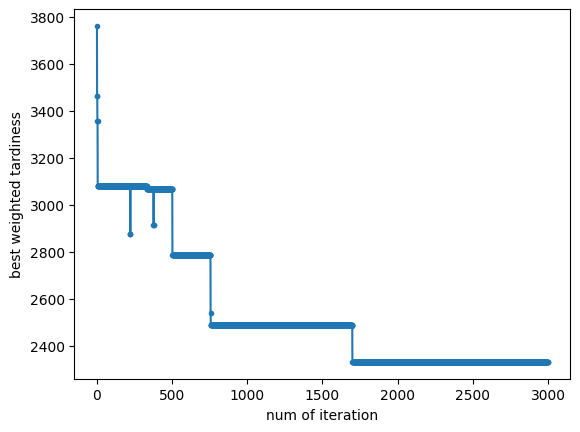

In [ ]:
GA_job_shop(param_population_size=40, param_offspring_size=30, mutation_rate=0.1)

shape of population_list: (40, 20)
Iter #0 Best tardiness is 4183, the job sequence is [10, 9, 11, 3, 16, 12, 15, 8, 7, 0, 1, 5, 18, 6, 17, 4, 14, 13, 2, 19] (has_progress)
Iter #1 Best tardiness is 3727, the job sequence is [10, 11, 8, 15, 6, 17, 7, 9, 19, 12, 3, 0, 1, 4, 16, 2, 14, 13, 18, 5] (has_progress)
Iter #2 Best tardiness is 3263, the job sequence is [11, 19, 4, 3, 16, 12, 15, 8, 7, 13, 6, 9, 2, 0, 17, 5, 1, 10, 14, 18] (has_progress)
Iter #6 Best tardiness is 3247, the job sequence is [1, 11, 4, 3, 16, 12, 15, 8, 7, 13, 19, 9, 10, 6, 17, 0, 14, 2, 5, 18] (has_progress)
Iter #7 Best tardiness is 2974, the job sequence is [11, 10, 4, 3, 16, 12, 15, 8, 7, 13, 19, 6, 9, 17, 0, 1, 14, 2, 5, 18] (has_progress)
Iter #9 Best tardiness is 2909, the job sequence is [19, 11, 4, 3, 16, 12, 15, 8, 7, 13, 0, 9, 6, 1, 17, 5, 10, 2, 14, 18] (has_progress)
Iter #10 Best tardiness is 2459, the job sequence is [11, 10, 4, 3, 15, 16, 7, 8, 6, 13, 19, 12, 9, 17, 0, 1, 14, 2, 5, 18] (has_progress

(2327, [19, 11, 4, 3, 15, 16, 7, 8, 6, 13, 0, 9, 12, 1, 17, 5, 10, 2, 14, 18])

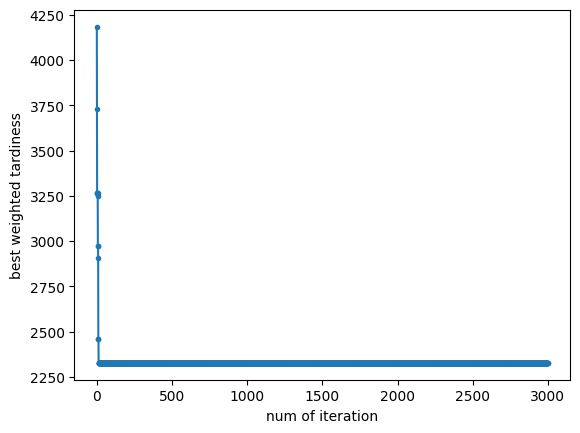

In [ ]:
# 只提高 `mutation_rate = 0.2`
GA_job_shop(param_population_size=40, param_offspring_size=30, mutation_rate=0.2)

shape of population_list: (40, 20)
Iter #0 Best tardiness is 4210, the job sequence is [11, 13, 16, 3, 2, 9, 0, 7, 6, 12, 15, 10, 17, 1, 8, 5, 19, 4, 14, 18] (has_progress)
Iter #1 Best tardiness is 3130, the job sequence is [8, 11, 0, 16, 15, 9, 4, 7, 10, 17, 13, 1, 14, 5, 19, 3, 6, 2, 12, 18] (has_progress)
Iter #4 Best tardiness is 2787, the job sequence is [8, 11, 3, 16, 15, 9, 4, 7, 10, 17, 12, 0, 14, 5, 1, 13, 6, 2, 19, 18] (has_progress)
Iter #134 Best tardiness is 2712, the job sequence is [8, 11, 3, 16, 15, 9, 4, 7, 19, 17, 10, 0, 13, 2, 6, 12, 14, 1, 18, 5] (has_progress)
Iter #135 Best tardiness is 2657, the job sequence is [8, 11, 3, 16, 15, 9, 4, 7, 10, 17, 19, 0, 13, 2, 6, 12, 14, 1, 18, 5] (has_progress)
Iter #387 Best tardiness is 2585, the job sequence is [10, 11, 3, 16, 15, 8, 4, 7, 0, 12, 19, 17, 13, 2, 9, 1, 14, 5, 6, 18] (has_progress)
Iter #388 Best tardiness is 2522, the job sequence is [9, 11, 3, 16, 15, 8, 4, 7, 0, 17, 19, 10, 13, 2, 6, 12, 14, 1, 18, 5] (has_p

(2175, [11, 19, 3, 16, 15, 8, 4, 7, 0, 9, 13, 12, 6, 10, 1, 17, 14, 5, 18, 2])

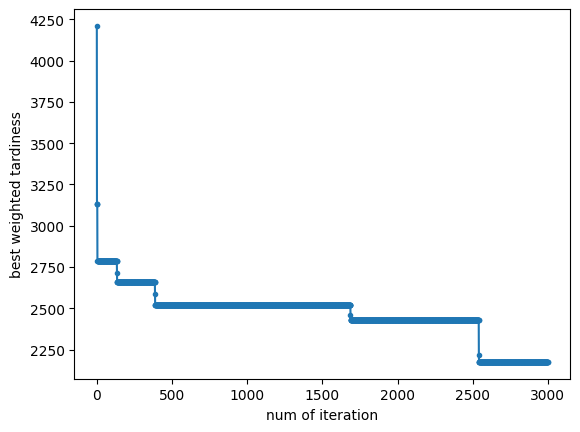

In [ ]:
# 只提高 `offspring_size = 40`
GA_job_shop(param_population_size=40, param_offspring_size=40, mutation_rate=0.1)

shape of population_list: (80, 20)
Iter #0 Best tardiness is 4251, the job sequence is [3, 16, 4, 15, 17, 19, 18, 0, 5, 11, 6, 9, 12, 8, 1, 13, 10, 7, 2, 14] (has_progress)
Iter #1 Best tardiness is 4019, the job sequence is [11, 19, 4, 7, 6, 0, 8, 12, 17, 5, 16, 15, 10, 2, 1, 14, 9, 13, 3, 18] (has_progress)
Iter #2 Best tardiness is 3752, the job sequence is [8, 11, 5, 4, 16, 10, 14, 13, 15, 19, 0, 7, 9, 1, 6, 12, 2, 17, 18, 3] (has_progress)
Iter #3 Best tardiness is 2982, the job sequence is [3, 19, 4, 0, 15, 16, 7, 9, 10, 11, 6, 17, 12, 8, 1, 13, 5, 18, 2, 14] (has_progress)
Iter #6 Best tardiness is 2916, the job sequence is [3, 11, 5, 0, 15, 16, 7, 9, 10, 19, 6, 13, 4, 1, 8, 12, 2, 17, 18, 14] (has_progress)
Iter #7 Best tardiness is 2522, the job sequence is [3, 19, 4, 8, 11, 15, 7, 9, 10, 0, 6, 16, 12, 17, 1, 13, 5, 18, 2, 14] (has_progress)
Iter #1386 Best tardiness is 2200, the job sequence is [11, 8, 4, 3, 9, 15, 7, 16, 10, 0, 6, 12, 17, 5, 19, 13, 1, 18, 2, 14] (has_progre

(2200, [11, 8, 4, 3, 9, 15, 7, 16, 10, 0, 6, 12, 17, 5, 19, 13, 1, 18, 2, 14])

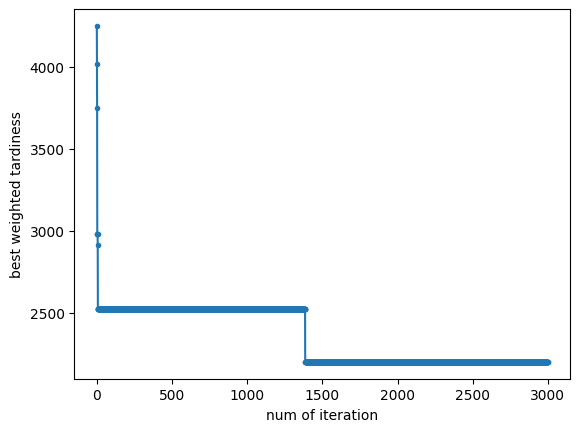

In [ ]:
# 只提高 `population_size = 80`
GA_job_shop(param_population_size=80, param_offspring_size=30, mutation_rate=0.1)

shape of population_list: (80, 20)
Iter #0 Best tardiness is 3143, the job sequence is [11, 16, 0, 3, 19, 15, 8, 7, 13, 12, 10, 5, 4, 1, 2, 9, 17, 14, 18, 6] (has_progress)
Iter #3 Best tardiness is 2788, the job sequence is [11, 16, 0, 3, 15, 1, 4, 7, 8, 12, 10, 5, 13, 19, 2, 9, 17, 14, 18, 6] (has_progress)
Iter #165 Best tardiness is 2745, the job sequence is [11, 15, 9, 3, 19, 16, 4, 7, 0, 12, 1, 5, 10, 8, 13, 2, 17, 14, 18, 6] (has_progress)
Iter #205 Best tardiness is 2213, the job sequence is [16, 11, 3, 15, 19, 8, 4, 7, 0, 6, 1, 12, 10, 5, 13, 9, 17, 14, 18, 2] (has_progress)
Iter #1156 Best tardiness is 2183, the job sequence is [16, 11, 9, 15, 4, 3, 7, 1, 0, 6, 8, 19, 10, 12, 13, 17, 5, 14, 18, 2] (has_progress)
Iter #1157 Best tardiness is 2143, the job sequence is [16, 11, 8, 15, 4, 3, 7, 1, 0, 6, 19, 12, 10, 5, 13, 9, 17, 14, 18, 2] (has_progress)
total_time: 17.65 seconds.


(2143, [16, 11, 8, 15, 4, 3, 7, 1, 0, 6, 19, 12, 10, 5, 13, 9, 17, 14, 18, 2])

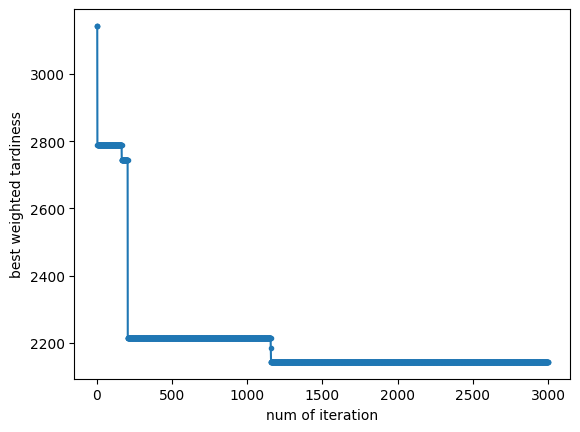

In [ ]:
# 三個參數一起調高
GA_job_shop(param_population_size=80, param_offspring_size=40, mutation_rate=0.2)